In [1]:
!pip install umap_learn -q
!pip install sentence_transformers -q

     |████████████████████████████████| 86 kB 2.4 MB/s 
     |████████████████████████████████| 1.1 MB 16.7 MB/s 
     |████████████████████████████████| 78 kB 3.8 MB/s 
     |████████████████████████████████| 3.1 MB 11.3 MB/s 
     |████████████████████████████████| 3.3 MB 37.2 MB/s 
     |████████████████████████████████| 1.2 MB 57.2 MB/s 
     |████████████████████████████████| 59 kB 8.6 MB/s 
     |████████████████████████████████| 596 kB 58.6 MB/s 
     |████████████████████████████████| 895 kB 51.7 MB/s 


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import umap.umap_ as umap
import string 
import time
from gensim import corpora
import gensim

In [3]:
ntopic = 20
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
!pip install stop_words

  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32912 sha256=6d70ac7a55c0a9abb75007d2161295fb87bb5f70214f2aef0d57aa188efdc7d7
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [5]:
from stop_words import get_stop_words

stop_words = get_stop_words('en')

In [6]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

In [7]:
from pprint import pprint
num_topics = len( set(newsgroups_train.target_names) )
print("num_topics : ",num_topics )
pprint(list(newsgroups_train.target_names))

num_topics :  20
['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [8]:
#Append sentences from newsgroup documents to raw sentences
raw_sentences = []
for s in newsgroups_train.data:
  raw_sentences.append( s )

In [9]:
import re


def only_letters(tested_string):
    for letter in tested_string:
        if letter not in "abcdefghijklmnopqrstuvwxyz":
            return False
    return True

#I just did an adhoc cleaning, as I see documents
#have some non English characters, so I use above method only_letters
#to filter instead of default isalpha python method
def clean_data(s): 
    s = s.replace(">","").lower()
    if "lines:" in s :
        index = s.index("lines:")
        s = s[index+10:] 
        
    word_list = word_tokenize(s)
    cleaned = []
    for w in word_list:
        if w not in stop_words:
            if w in string.punctuation or only_letters(w):
                if w in string.punctuation or len( set(w) ) > 1:
                    cleaned.append( w)
    return " ".join(cleaned) ,cleaned           
            

#from documents clean sentence and return vocublary of sentence
def build_data(docs):

    n_docs = len(docs)
    sentences = []  # sentences
    token_lists = []  # words vocublary
    
    for i in range(len(docs)):
        sentence,token_list = clean_data(docs[i])
        if token_list: #if not all items eleminated
            sentences.append(sentence)
            token_lists.append(token_list)
        
    return sentences, token_lists

In [10]:

print("Number of raw sentences ", len(raw_sentences))

Number of raw sentences  11314


In [11]:
print("Sample raw sentence \n", raw_sentences[10])

Sample raw sentence 
 From: irwin@cmptrc.lonestar.org (Irwin Arnstein)
Subject: Re: Recommendation on Duc
Summary: What's it worth?
Distribution: usa
Expires: Sat, 1 May 1993 05:00:00 GMT
Organization: CompuTrac Inc., Richardson TX
Keywords: Ducati, GTS, How much? 
Lines: 13

I have a line on a Ducati 900GTS 1978 model with 17k on the clock.  Runs
very well, paint is the bronze/brown/orange faded out, leaks a bit of oil
and pops out of 1st with hard accel.  The shop will fix trans and oil 
leak.  They sold the bike to the 1 and only owner.  They want $3495, and
I am thinking more like $3K.  Any opinions out there?  Please email me.
Thanks.  It would be a nice stable mate to the Beemer.  Then I'll get
a jap bike and call myself Axis Motors!

-- 
-----------------------------------------------------------------------
"Tuba" (Irwin)      "I honk therefore I am"     CompuTrac-Richardson,Tx
irwin@cmptrc.lonestar.org    DoD #0826          (R75/6)
---------------------------------------------

In [12]:
sentences, token_lists = build_data(raw_sentences )

In [13]:
print(len(sentences))


11300


In [14]:
print("Sentence after cleaning :\n", sentences[10])

Sentence after cleaning :
 line ducati model clock . runs well , paint faded , leaks bit oil pops hard accel . shop will fix trans oil leak . sold bike owner . want $ , thinking like $ . opinions ? please email . thanks . nice stable mate beemer . get jap bike call axis motors ! - tuba ( irwin ) honk therefore , tx irwin @ dod # ( ) -


In [15]:
#get tfidf of documents
def get_tfidf_embedding(items):
  tfidf = TfidfVectorizer()
  embeddings = tfidf.fit_transform(items)
  return embeddings


In [16]:
#Generate embedding with tfidf
embedding_tf_idf = get_tfidf_embedding( sentences )
print("Shape of sentences applied tf-idf :", embedding_tf_idf.shape)

Shape of sentences applied tf-idf : (11300, 70025)


In [17]:

print("Type of tf-idf vector :", type( embedding_tf_idf[10] ) )
print("Sample of tf-idf vector :",  embedding_tf_idf[10] ) 
#you can see tf-idf scores for row 10

Type of tf-idf vector : <class 'scipy.sparse.csr.csr_matrix'>
Sample of tf-idf vector :   (0, 16885)	0.1019245206488971
  (0, 63256)	0.1300379818490607
  (0, 61177)	0.10248417998509939
  (0, 27491)	0.19116528238440475
  (0, 30643)	0.395657466237793
  (0, 62993)	0.20205176551427106
  (0, 39992)	0.16214809597643454
  (0, 4427)	0.16214809597643454
  (0, 8353)	0.08484786254434096
  (0, 31088)	0.18843712678970137
  (0, 5442)	0.18378908153032092
  (0, 37178)	0.19116528238440475
  (0, 57864)	0.14264099467878236
  (0, 61276)	0.1029290163139807
  (0, 66456)	0.06672723943664648
  (0, 44449)	0.12605749147306597
  (0, 6074)	0.22106176110281708
  (0, 56825)	0.11891999988948708
  (0, 34443)	0.166704408239847
  (0, 62368)	0.17820315304012144
  (0, 55489)	0.13754380000393723
  (0, 295)	0.1942582101038083
  (0, 47138)	0.1629904633968193
  (0, 43271)	0.261760698538891
  (0, 34448)	0.17238206972601447
  (0, 20755)	0.1978287331188965
  (0, 44594)	0.13812289394651117
  (0, 53132)	0.10808155525151747
  (0, 

In [18]:
def predict_topics_with_kmeans(embeddings,num_topics):
  kmeans_model = KMeans(num_topics)
  kmeans_model.fit(embeddings)
  topics_labels = kmeans_model.predict(embeddings)
  return topics_labels


    
def plot_embeddings(embedding, labels,title):

    labels = np.array( labels )
    distinct_labels =  set( labels )
    
    n = len(embedding)
    counter = Counter(labels)
    for i in range(len( distinct_labels )):
        ratio = (counter[i] / n )* 100
        cluster_label = f"cluster {i}: { round(ratio,2)}"
        x = embedding[:, 0][labels == i]
        y = embedding[:, 1][labels == i]
        plt.plot(x, y, '.', alpha=0.4, label= cluster_label)
    plt.legend(title="Topic",loc = 'upper left', bbox_to_anchor=(1.01,1))
    plt.title(title)
    

def reduce_umap(embedding):
  reducer = umap.UMAP() #umap.UMAP()
  embedding_umap = reducer.fit_transform( embedding  )
  return embedding_umap

def reduce_pca(embedding):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform( embedding )
    print( "pca explained_variance_ ",pca.explained_variance_)
    print( "pca explained_variance_ratio_ ",pca.explained_variance_ratio_)
    
    return reduced

def reduce_tsne(embedding):
    tsne = TSNE(n_components=2)
    reduced = tsne.fit_transform( embedding )
    
    return reduced

In [19]:
#Apply kmeans to raw vectors
labels_tfidf_raw  = predict_topics_with_kmeans(embedding_tf_idf,num_topics)



In [20]:
print("Embedding Tf-idf shape :",embedding_tf_idf.shape)

Embedding Tf-idf shape : (11300, 70025)


In [21]:
#Apply kmeans to umap vectors
embedding_tf_idf_umap =  reduce_umap( embedding_tf_idf )
labels_tfidf_umap  = predict_topics_with_kmeans(embedding_tf_idf_umap,num_topics)



/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [22]:
print("Embedding shape after umap",embedding_tf_idf_umap.shape)

Embedding shape after umap (11300, 2)


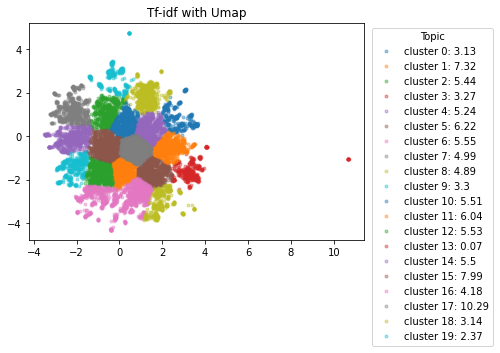

In [23]:
plot_embeddings(embedding_tf_idf_umap,labels_tfidf_umap,"Tf-idf with Umap")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


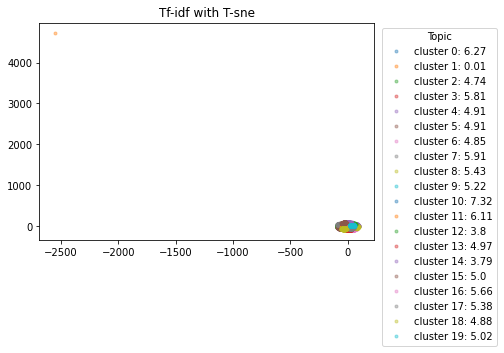

In [24]:
embedding_tf_idf_tsne =  reduce_tsne( embedding_tf_idf )
labels_tfidf_tsne  = predict_topics_with_kmeans(embedding_tf_idf_tsne,num_topics)

plot_embeddings(embedding_tf_idf_tsne,labels_tfidf_tsne,"Tf-idf with T-sne")

In [25]:
#The silhouette value is a measure of how similar an object is to its own cluster compared to other clusters

In [26]:
#The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. 
#Negative values generally indicate that a sample has 
#been assigned to the wrong cluster, as a different cluster is more similar.

In [27]:
print("Silhouette score:" )
print("without dim reduction :", silhouette_score(embedding_tf_idf , labels_tfidf_raw) )
print("with Tf-idf   Umap    :", silhouette_score(embedding_tf_idf_umap, labels_tfidf_umap) )
print("with Tf-idf   T-sne   :",  silhouette_score(embedding_tf_idf_tsne, labels_tfidf_tsne) )

Silhouette score:
without dim reduction : 0.005768852078802568
with Tf-idf   Umap    : 0.36549282
with Tf-idf   T-sne   : 0.35064137


In [28]:
def get_document_topic_lda(model, corpus, k):
   n_doc = len(corpus)
   #init a vector of size number of docs x clusters
   document_topic_mapping = np.zeros((n_doc, k))
   for i in range(n_doc):
     # for each document create a vector of probability document belonging to topic
     for topic, prob in model.get_document_topics(corpus[i]):
       document_topic_mapping[i, topic] = prob

   return document_topic_mapping

In [29]:
print("Number of words in token list :", len( token_lists ))

Number of words in token list : 11300


In [30]:


dictionary = corpora.Dictionary(token_lists)
corpus = [dictionary.doc2bow(text) for text in token_lists]
k = ntopic
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=k, id2word=dictionary,passes=20)

embedding_lda = get_document_topic_lda(ldamodel, corpus, k)

In [31]:
#This is not a document embedding , I just use it as it is.
print("LDA vector shape :", embedding_lda.shape )

LDA vector shape : (11300, 20)


In [32]:

for i,topic in enumerate(embedding_lda[10].flatten()):
    print("Topic ",i+1,") ", embedding_lda[10].flatten()[i])

Topic  1 )  0.0
Topic  2 )  0.0
Topic  3 )  0.0
Topic  4 )  0.020542414858937263
Topic  5 )  0.0
Topic  6 )  0.0
Topic  7 )  0.0
Topic  8 )  0.0
Topic  9 )  0.12325048446655273
Topic  10 )  0.3016377389431
Topic  11 )  0.0
Topic  12 )  0.27333226799964905
Topic  13 )  0.11957136541604996
Topic  14 )  0.031009120866656303
Topic  15 )  0.0
Topic  16 )  0.0
Topic  17 )  0.0
Topic  18 )  0.12162884324789047
Topic  19 )  0.0
Topic  20 )  0.0


In [33]:
print("Number of tokens : ", len( token_lists ))
print("Sample item from corpus length :", len( corpus[100] ) )
print("Sample item from corpus vector :", corpus[100]  )

Number of tokens :  11300
Sample item from corpus length : 55
Sample item from corpus vector : [(0, 3), (1, 17), (114, 1), (179, 1), (262, 1), (271, 5), (297, 3), (300, 2), (313, 17), (376, 1), (465, 1), (488, 1), (494, 1), (830, 2), (1000, 4), (1159, 1), (1160, 1), (1188, 3), (1670, 1), (1686, 8), (1782, 1), (4287, 1), (4368, 3), (5086, 1), (5087, 1), (5088, 1), (5089, 1), (5090, 1), (5091, 1), (5092, 2), (5093, 1), (5094, 1), (5095, 2), (5096, 2), (5097, 1), (5098, 2), (5099, 1), (5100, 1), (5101, 1), (5102, 1), (5103, 2), (5104, 1), (5105, 1), (5106, 2), (5107, 1), (5108, 1), (5109, 1), (5110, 1), (5111, 1), (5112, 1), (5113, 1), (5114, 3), (5115, 1), (5116, 1), (5117, 1)]


In [34]:
print("Token 0 : ", dictionary.id2token[0] )

Token 0 :  ,


In [35]:
list(token_lists[100] ).count(  dictionary.id2token[10] )

0

In [36]:
ldamodel.get_document_topics( corpus[0] )

[(8, 0.5378967), (11, 0.19651951), (12, 0.054379627), (17, 0.19870421)]

In [37]:
srtd = sorted( ldamodel.get_document_topics( corpus[0] ) , key=lambda x: x[1], reverse=True)
print( srtd )
print( srtd[0][0] )

[(8, 0.5378118), (17, 0.1987171), (11, 0.19670407), (12, 0.05426703)]
8


In [38]:
labels_lda = []
for line in corpus :
  line_labels = sorted( ldamodel.get_document_topics( line ) , key=lambda x: x[1], reverse=True)
  #1st 0 is for selecting top item, and 2nd 0 is for index of tuple
  top_topic = line_labels[0][0]
  labels_lda.append(  top_topic)

In [39]:
np.array(labels_lda ).shape

(11300,)

In [40]:
#Since LDA already has a low dimension num_topic ( 20 ) , dimension reductions
#will not yield good results

In [41]:
embedding_umap_lda = reduce_umap( embedding_lda  )

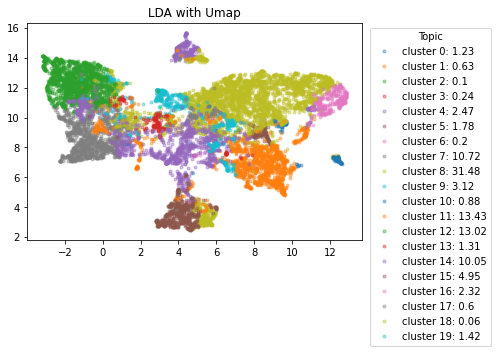

In [42]:
plot_embeddings(embedding_umap_lda, labels_lda,"LDA with Umap")

pca explained_variance_  [0.05518968 0.03900629]
pca explained_variance_ratio_  [0.24158588 0.17074513]


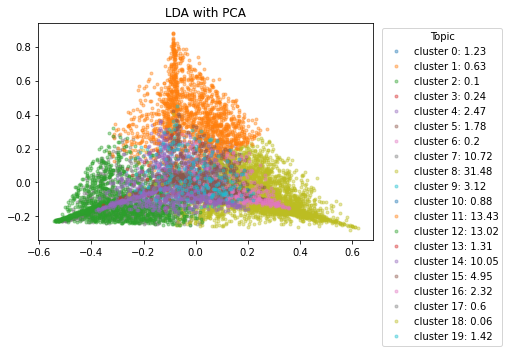

In [43]:
embedding_pca_lda = reduce_pca(embedding_lda  )
plot_embeddings(embedding_pca_lda, labels_lda,"LDA with PCA")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


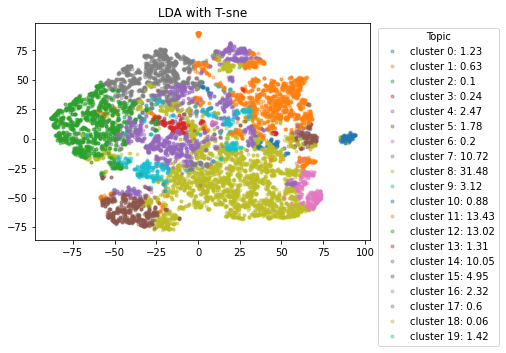

In [44]:
embedding_tsne_lda = reduce_tsne(embedding_lda  )
plot_embeddings(embedding_tsne_lda, labels_lda,"LDA with T-sne")

In [45]:
print("Silhouette score:" )
print("LDA          : ", silhouette_score(embedding_lda, labels_lda) )

print("LDA with PCA : ", silhouette_score(embedding_pca_lda, labels_lda) )

print("LDA with TSNE : ", silhouette_score(embedding_tsne_lda, labels_lda) )

print("LDA with UMAP : ", silhouette_score(embedding_umap_lda, labels_lda) )

Silhouette score:
LDA          :  0.2308199393732743
LDA with PCA :  -0.0973206164632494
LDA with TSNE :  -0.046501454
LDA with UMAP :  -0.024417648


In [46]:
from sentence_transformers import SentenceTransformer
model_bert = SentenceTransformer('bert-base-nli-max-tokens')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.97k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/397 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [47]:
embedding_bert = np.array(model_bert.encode(sentences, show_progress_bar=True))


Batches:   0%|          | 0/354 [00:00<?, ?it/s]

In [48]:
#Bert embeddings are shape of 768
print("Bert Embedding shape", embedding_bert.shape)
print("Bert Embedding sample", embedding_bert[0][0:50])

Bert Embedding shape (11300, 768)
Bert Embedding sample [ 0.4772099   1.4122616   1.2466784   0.2571226   1.3472137   0.05440109
  0.51056963  0.5357249   0.88252896 -0.00200425  1.2273107   1.3862454
  1.5305246   0.3519501   0.07823961  0.68975747  1.7512577   1.0708536
  1.1696897   0.6520601  -0.03964772 -0.01581212  0.72166926  0.05700604
  1.2987404   1.5801817   0.7318034   1.0034984  -0.5058814  -0.04584683
  0.17520963  1.59084     0.5122799   0.7542707   0.9528054   0.55644315
  0.8194796   0.05092393  0.26165482  0.91304004  0.63735193  0.4096315
  0.78955114  0.46445006 -0.31118914  1.149907    0.7721692   1.4973234
  0.63816017  1.0090785 ]


In [49]:
#Apply Kmeans without dimension reduction
labels_bert_raw  = predict_topics_with_kmeans(embedding_bert,num_topics)

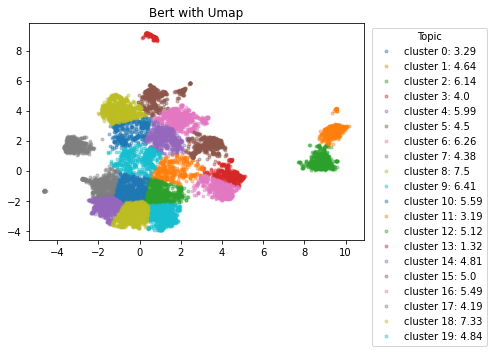

In [50]:
#Apply Kmeans for Bert Vectors  with Umap  dimension reduction

embedding_umap_bert = reduce_umap( embedding_bert )
labels_bert_umap  = predict_topics_with_kmeans(embedding_umap_bert,num_topics)
plot_embeddings(embedding_umap_bert, labels_bert_umap,"Bert with Umap")

pca explained_variance_  [10.198976   5.7838244]
pca explained_variance_ratio_  [0.09949103 0.05642122]


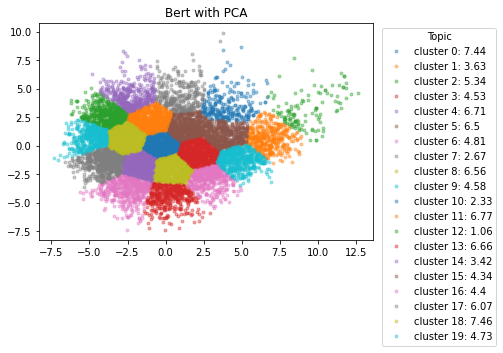

In [51]:
#Apply Kmeans for Bert Vectors  with PCA  dimension reduction

embedding_bert_pca =  reduce_pca( embedding_bert )
labels_bert_pca  = predict_topics_with_kmeans(embedding_bert_pca,num_topics)

plot_embeddings(embedding_bert_pca,labels_bert_pca,"Bert with PCA")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


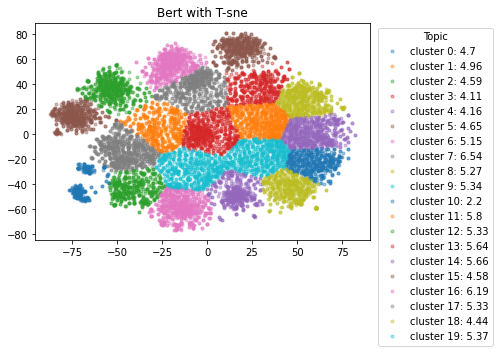

In [52]:
#Apply Kmeans for Bert Vectors  with T-sne  dimension reduction


embedding_bert_tsne =  reduce_tsne( embedding_bert )
labels_bert_tsne  = predict_topics_with_kmeans(embedding_bert_tsne,num_topics)
plot_embeddings(embedding_bert_tsne,labels_bert_tsne,"Bert with T-sne")


In [53]:
print("Silhouette score:" )

print("Raw Bert" ,silhouette_score(embedding_bert, labels_bert_raw) )

print("Bert with PCA" ,  silhouette_score(embedding_bert_pca, labels_bert_pca) )

print("Bert with Tsne" , silhouette_score(embedding_bert_tsne, labels_bert_tsne) )


print("Bert with Umap" ,  silhouette_score(embedding_umap_bert , labels_bert_umap ) )

Silhouette score:
Raw Bert 0.046196785
Bert with PCA 0.32483777
Bert with Tsne 0.39341545
Bert with Umap 0.45956552
